<h1>Social Media Sanctions and Misinformation Sharing</h1>

<h4>Import essential libraries</h4>

The initial step is to import the required libraries. These include:

- `pandas`: For data manipulation and analysis.
- `seaborn` and `matplotlib.pyplot`: For data visualization.
- `numpy`: For numerical computations.
- `scipy.stats` and `statsmodels`: For statistical analysis.
- `os`: To interact with the file system.
- `sklearn`: For machine learning tasks such as metrics and PCA.

These libraries are essential for reading the dataset, performing statistical tests, and visualizing results.

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import os
import statsmodels.api as sm  # Importing statsmodels
from statsmodels.discrete.discrete_model import Probit
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from scipy.stats import mstats
from statsmodels.stats.multitest import multipletests
from scipy.stats import zscore, ttest_ind


<h4>Loading the Dataset</h4>

Here, we define the filename (`mosleh_et_al_data.csv`) and check if it exists in the current working directory.
If the file is not found, an error is raised. The dataset is then read into a `pandas` DataFrame. 
Missing values in the DataFrame are replaced with column means to handle incomplete data gracefully.

In [2]:
# Define the filename
filename = "mosleh_et_al_data.csv"

# Check if the file exists in the current working directory
if not os.path.exists(filename):
    raise FileNotFoundError(f"The file '{filename}' was not found in the current working directory. Please ensure it is present.")

# Read the file
df = pd.read_csv(filename)

# Fill missing values with the column mean
df.fillna(df.mean(), inplace=True)

### Crosstabulation and Suspension Rates

This part creates a crosstab to examine the relationship between `politics_hashtag` and `suspended`. Suspension rates are calculated for the two groups (`#Trump2020` and `#VoteBidenHarris2020`),
and the likelihood ratio is computed to compare the two groups. Additionally, a chi-squared test is performed to check the statistical significance of the association.

In [3]:
crosstab = pd.crosstab(df['politics_hashtag'], df['suspended'])
print("Crosstabulation:")
print(crosstab)

# Calculate suspension rates
suspension_trump = crosstab.loc[1, 1] / crosstab.loc[1].sum()  # 1 = #Trump2020
suspension_biden = crosstab.loc[0, 1] / crosstab.loc[0].sum()  # 0 = #VoteBidenHarris2020

likelihood_ratio = suspension_trump / suspension_biden
print(f"\nSuspension likelihood ratio: {likelihood_ratio:.2f}")

# Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(crosstab)
print("\nChi-squared Test Results:")
print(f"Chi-squared statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")

Crosstabulation:
suspended            0    1
politics_hashtag           
0                 4295  200
1                 3623  882

Suspension likelihood ratio: 4.40

Chi-squared Test Results:
Chi-squared statistic: 485.47
P-value: 0.0000
Degrees of freedom: 1


### Data Preparation for Low-Quality News Sharing Analysis
Rows with missing values in `lowqual_pr2019_fc` and `lowqual_pr2019_crowd` are dropped to ensure valid comparisons. These columns are standardized using z-scores for normalization.

In [4]:
# Drop rows with NaN values in specific columns
df = df.dropna(subset=['lowqual_pr2019_fc', 'lowqual_pr2019_crowd'])

# Standardize the low-quality sharing columns
df['lowqual_fc_z'] = zscore(df['lowqual_pr2019_fc'])
df['lowqual_crowd_z'] = zscore(df['lowqual_pr2019_crowd'])

### Visualizing Low-Quality News Sharing Distributions
Separate the data based on `politics_hashtag` and plot the distribution of low-quality news sharing for both fact-checkers and crowdsourcing. The colors have been chosen to distinguish between the two groups (`#Trump2020` and `#VoteBidenHarris2020`).


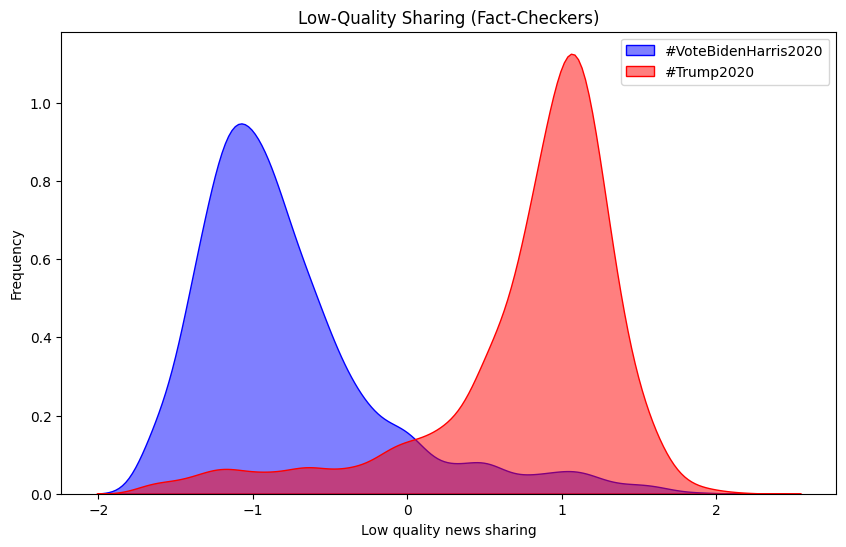

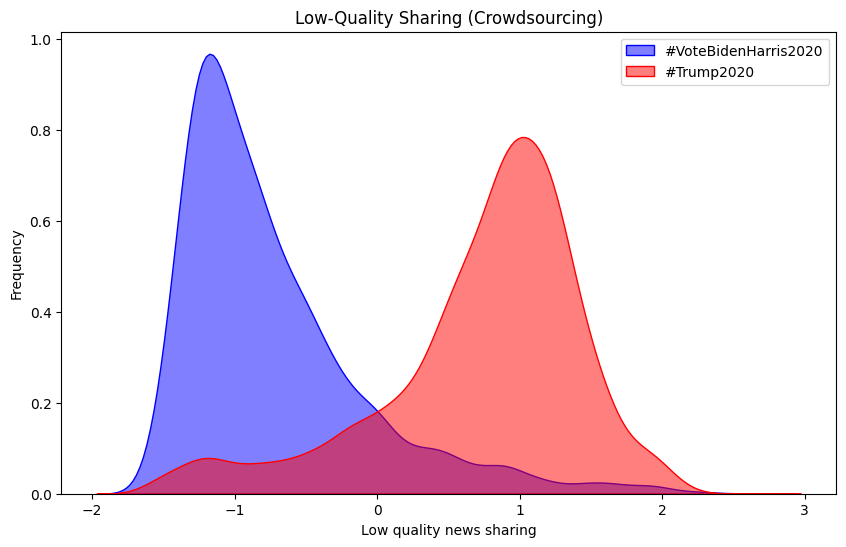

In [20]:
# Separate data by politics_hashtag
fc_trump = df[df['politics_hashtag'] == 1]['lowqual_fc_z']
fc_biden = df[df['politics_hashtag'] == 0]['lowqual_fc_z']

crowd_trump = df[df['politics_hashtag'] == 1]['lowqual_crowd_z']
crowd_biden = df[df['politics_hashtag'] == 0]['lowqual_crowd_z']

# Set color palette for plots
sns.set_palette("Set1")

# Plot distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(fc_biden, color='blue', label='#VoteBidenHarris2020', fill=True, alpha=0.5)
sns.kdeplot(fc_trump, color='red', label='#Trump2020', fill=True, alpha=0.5)
plt.title('Low-Quality Sharing (Fact-Checkers)')
plt.xlabel('Low quality news sharing')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(crowd_biden, color='blue', label='#VoteBidenHarris2020', fill=True, alpha=0.5)
sns.kdeplot(crowd_trump, color='red', label='#Trump2020', fill=True, alpha=0.5)
plt.title('Low-Quality Sharing (Crowdsourcing)')
plt.xlabel('Low quality news sharing')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Comparing Mean Low-Quality News Sharing Between Groups
Independent t-tests are used to determine if there is a statistically significant difference in mean low-quality news sharing between `#Trump2020` and `#VoteBidenHarris2020`. The analysis is performed separately for both fact-checkers and crowdsourcing metrics.

In [6]:
# Perform t-tests for low-quality sharing columns
fc_ttest = ttest_ind(fc_trump, fc_biden, equal_var=False)
crowd_ttest = ttest_ind(crowd_trump, crowd_biden, equal_var=False)

print("\nT-Test Results (Fact-Checkers):")
print(f"T-statistic: {fc_ttest.statistic:.2f}, P-value: {fc_ttest.pvalue:.4f}")

print("\nT-Test Results (Crowdsourcing):")
print(f"T-statistic: {crowd_ttest.statistic:.2f}, P-value: {crowd_ttest.pvalue:.4f}")



T-Test Results (Fact-Checkers):
T-statistic: 118.65, P-value: 0.0000

T-Test Results (Crowdsourcing):
T-statistic: 102.11, P-value: 0.0000


This part of the code defines two functions, `cohens_d` and `hedges_g`, which are used to calculate effect size metrics. 

The `cohens_d` function calculates Cohen's d, a statistical measure that quantifies the standardized difference between the means of two groups.
The `hedges_g` function calculates Hedges' g, which is a variation of Cohen's d that adjusts for small sample sizes. It takes the effect size (Cohen's d) and the sample sizes of the two groups as input. The function applies a correction factor to account for bias in smaller samples, resulting in a more accurate measure of effect size.

In [7]:
# Function to calculate Cohen's d
def cohens_d(mean1, mean2, std1, std2, n1, n2):
    pooled_sd = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    d = (mean1 - mean2) / pooled_sd
    return d

# Function to calculate Hedges' g
def hedges_g(d, n1, n2):
    correction = 1 - (3 / (4 * (n1 + n2) - 9))
    g = correction * d
    return g


This section of the code performs a statistical comparison of specific columns between two groups, defined by the politics_hashtag variable in the dataset. The analysis focuses on the columns listed in the columns variable, which represent various low-quality misinformation indicators.The code then performs a t-test to assess whether there is a statistically significant difference in the means of the two groups. The ttest_ind function is used with equal_var=False, which accounts for the possibility of unequal variances between the groups. This produces a t-statistic and a p-value for the comparison.Next, the code calculates descriptive statistics for each group, including the mean, standard deviation, and sample size. These values are used to compute two effect size metrics: Cohen’s d and Hedges’ g. Cohen’s d measures the standardized difference between group means, while Hedges’ g adjusts for potential bias in small sample sizes.The results for each column are stored in a dictionary, where the keys are column names and the values are sub-dictionaries containing the calculated statistics.


In [8]:
# Columns to analyze
columns = [
    'lowqual_pr2019_fc',
    'lowqual_afm',
    'lowqual_mbfc',
    'lowqual_lasser2019',
    'lowqual_pr2019_crowd',
    'lowqual_pr2019_crowdrep'
]
# Perform t-test and calculate effect sizes for each column
results = {}
for column in columns:
    # Group data by politics_hashtag (0 for #VoteBidenHarris2020, 1 for #Trump2020)
    group_biden = df[df['politics_hashtag'] == 0][column].dropna()
    group_trump = df[df['politics_hashtag'] == 1][column].dropna()

    # Calculate t-test
    t_stat, p_value = ttest_ind(group_trump, group_biden, equal_var=False)

    # Calculate means, standard deviations, and sample sizes
    mean_trump, mean_biden = np.mean(group_trump), np.mean(group_biden)
    std_trump, std_biden = np.std(group_trump, ddof=1), np.std(group_biden, ddof=1)
    n_trump, n_biden = len(group_trump), len(group_biden)

    # Calculate Cohen's d and Hedges' g
    d = cohens_d(mean_trump, mean_biden, std_trump, std_biden, n_trump, n_biden)
    g = hedges_g(d, n_trump, n_biden)

    # Store the results
    results[column] = {
        'T-statistic': t_stat,
        'P-value': p_value,
        'Cohen\'s d': d,
        'Hedges\' g': g
    }

# Print results in a readable format
for column, stats in results.items():
    print(f"\nResults for {column}:")
    for key, value in stats.items():
        print(f"{key}: {value:.4f}")



Results for lowqual_pr2019_fc:
T-statistic: 118.6514
P-value: 0.0000
Cohen's d: 2.5013
Hedges' g: 2.5011

Results for lowqual_afm:
T-statistic: 102.6978
P-value: 0.0000
Cohen's d: 2.1644
Hedges' g: 2.1642

Results for lowqual_mbfc:
T-statistic: 97.5775
P-value: 0.0000
Cohen's d: 2.0573
Hedges' g: 2.0571

Results for lowqual_lasser2019:
T-statistic: 102.6778
P-value: 0.0000
Cohen's d: 2.1636
Hedges' g: 2.1634

Results for lowqual_pr2019_crowd:
T-statistic: 102.1060
P-value: 0.0000
Cohen's d: 2.1524
Hedges' g: 2.1522

Results for lowqual_pr2019_crowdrep:
T-statistic: 60.9961
P-value: 0.0000
Cohen's d: 1.2858
Hedges' g: 1.2857


Grouping the variables that will appear in the y and x axis of the heatmap respectively

In [9]:
# Create a custom blue gradient color palette
custom_cmap = sns.light_palette("seagreen", as_cmap=True)

# Create an empty DataFrame to store the correlation results
correlation_data = []

lowqual_cols = [
    'lowqual_pr2019_fc',
    'lowqual_lasser2019',
    'lowqual_mbfc',
    'lowqual_afm',
    'lowqual_pr2019_crowd',
    'lowqual_pr2019_crowdrep'
]

politics_cols = [
    'politics_followed',
    'politics_hashtag',
    'politics_sites1',
    'politics_sites2'
]


Below I calculate and visualize the pairwise correlations between low-quality news sources and political ideology indicators. It iterates through the specified columns of low-quality news sources and political indicators, computes the correlation coefficient for each pair, and stores the results in a DataFrame. This DataFrame is pivoted into a 2D format to create a heatmap that shows the strength of correlations using a color gradient. The heatmap uses a custom color palette and highlights correlations within a specified range (0.55 to 0.85) for clarity. This visualization provides insights into the relationships between these variables.

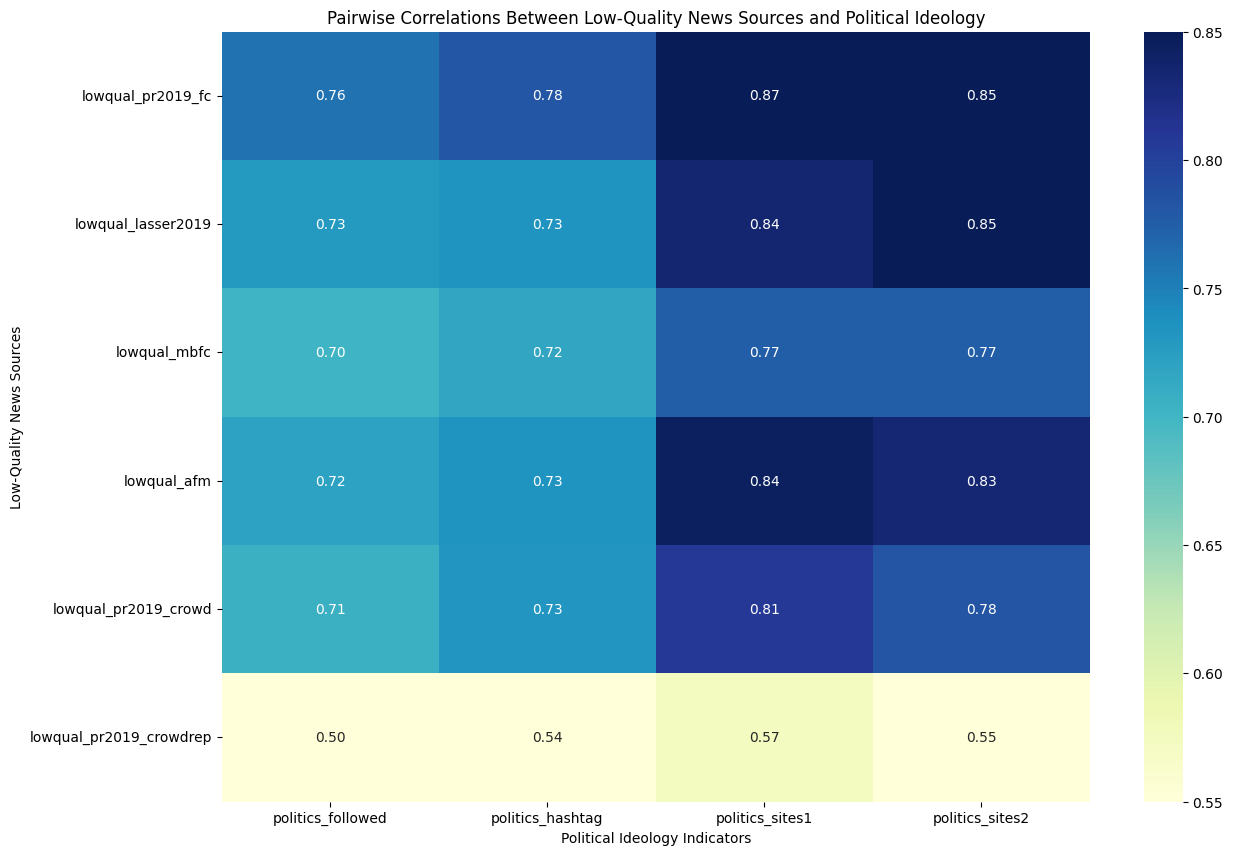

In [ ]:
for low_col in lowqual_cols:
    for pol_col in politics_cols:
        corr = df[low_col].corr(df[pol_col])
        correlation_data.append([low_col, pol_col, corr])

# Create a DataFrame from the correlation data
correlation_df = pd.DataFrame(correlation_data, columns=['Low-Quality News Sources', 'Political Ideology Indicator', 'Correlation'])

# Pivot the DataFrame 
heatmap_data = correlation_df.pivot(index='Low-Quality News Sources', columns='Political Ideology Indicator', values='Correlation')

# Ensure the order of low-quality news sources matches the specified order
heatmap_data = heatmap_data.reindex(lowqual_cols)

# Plot the heatmap with the custom color palette and limits
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', vmin=0.55, vmax=0.85, fmt=".2f")
plt.title('Pairwise Correlations Between Low-Quality News Sources and Political Ideology')
plt.xlabel('Political Ideology Indicators')
plt.ylabel('Low-Quality News Sources')
plt.show()


Creating a list of all the predictors, and defining the target variable for our next analysis

In [11]:
# List of predictors
predictors = [
    'politics_hashtag',
    'politics_sites1',
    'politics_sites2',
    'politics_followed',
    'lowqual_afm',
    'lowqual_mbfc',
    'lowqual_lasser2019',
    'lowqual_pr2019_fc',
    'lowqual_pr2019_crowd'
]

# Target variable
target = 'suspended'

This section performs data preprocessing by applying log transformations and winsorization to handle skewed distributions and outliers in the dataset. First, logarithmic transformations (base 10) are applied to several variables, including tweet counts, follower and friend counts, and their ratio, to reduce skewness and make the data more normally distributed. The +1 ensures that no values are undefined due to logarithms of zero.

Next, specific variables are winsorized to cap extreme values at the top 1%. Two groups of variables are processed: one group is entirely winsorized (both lower and upper limits), while the second group is capped only at the upper end. Winsorization reduces the influence of outliers while preserving the overall data structure. This preprocessing step prepares the dataset for further analysis by ensuring that extreme values do not disproportionately affect results.

In [12]:

# Log transform variables with a base of 10
df['log_repeated_tweet_count'] = np.log10(df['repeated_tweet_count'] + 1)
df['log_freq_pr_1h'] = np.log10(df['freq_pr_1h'] + 1)
df['log_num_followers'] = np.log10(df['num_followers'] + 1)
df['log_num_friends'] = np.log10(df['num_friends'] + 1)

# Create log_fol variable (log of friends to followers ratio)
df['log_fol'] = np.log10((df['num_friends'] + 1) / (df['num_followers'] + 1))

# Winsorize the specified variables at the top 1%
winsor_vars_upper = [
    'valence_neg', 'valence_neu', 'valence_pos', 'barbera_std',
    'politics_sites1_std', 'politics_sites2_ideo_std'
]
df[winsor_vars_upper] = df[winsor_vars_upper].apply(lambda x: mstats.winsorize(x, limits=[0, 0.01]))

# Winsorize the specified variables at the top 1% (upper side)
winsor_vars_upper_only = [
    'moral_outrage', 'rewire_abuse', 'rewire_hate', 'rewire_profanity',
    'rewire_violent', 'rewire_sexually_explicit', 'jigsaw_toxicity',
    'jigsaw_severe_toxicity', 'jigsaw_idenity_attack', 'jigsaw_insult',
    'jigsaw_profanity', 'jigsaw_threat'
]
df[winsor_vars_upper_only] = df[winsor_vars_upper_only].apply(lambda x: mstats.winsorize(x, limits=[0, 0.01]))

Here I perform Principal Component Analysis (PCA) to reduce the dimensionality of variables related to political orientation and creates a single composite score. First, the political orientation variables are selected and standardized to have a mean of 0 and a standard deviation of 1. Standardization ensures that all variables contribute equally to the PCA regardless of their original scales.

PCA is then applied to extract the first principal component, representing the dominant pattern of variation across the political orientation variables. The resulting component is added to the dataset as a new feature (pc1_politics), summarizing the political orientation into a single metric.

In [13]:
# PCA for political orientation
political_vars = ['politics_hashtag', 'politics_followed', 'politics_sites1', 'politics_sites2']
X_political = df[political_vars]

# Standardize the data for PCA
X_political_scaled = (X_political - X_political.mean()) / X_political.std()

# Perform PCA for political orientation
pca_political = PCA(n_components=1)
pc1_politics = pca_political.fit_transform(X_political_scaled)

# Add the PCA component to the DataFrame
df['pc1_politics'] = pc1_politics
# Prepare to store results
results = []

# Color map to distinguish categories
color_map = {
    'politics_hashtag': 'purple',
    'politics_sites1': 'purple',
    'politics_sites2': 'purple',
    'politics_followed': 'purple',
    'lowqual_afm': 'green',
    'lowqual_mbfc': 'green',
    'lowqual_lasser2019': 'green',
    'lowqual_pr2019_fc': 'green',
    'lowqual_pr2019_crowd': 'green'
}

Next, the following code evaluates the predictive performance of selected predictors using a Probit regression model and assesses the Area Under the Curve (AUC) for each predictor with bootstrapping. Here's how the process unfolds:

For each predictor, the process is repeated 100 times using bootstrap resampling. Each bootstrap sample is a random sample with replacement from the original data. The target variable `y_boot` and the selected predictor `X_boot` are extracted from the bootstrap sample. A constant term is added to `X_boot` to include an intercept in the Probit model.

A Probit regression model is then fitted to the bootstrap sample, and the p-value for the predictor is recorded. Probabilities predicted by the model are used to calculate the AUC, which measures the model's ability to distinguish between classes. The AUC values and p-values for each bootstrap iteration are stored.

After completing the 100 bootstrap iterations, the `Mean AUC`, 95% confidence intervals for AUC (using percentiles), and the mean p-value are calculated for the predictor. These metrics provide an understanding of the predictor's performance and statistical significance.

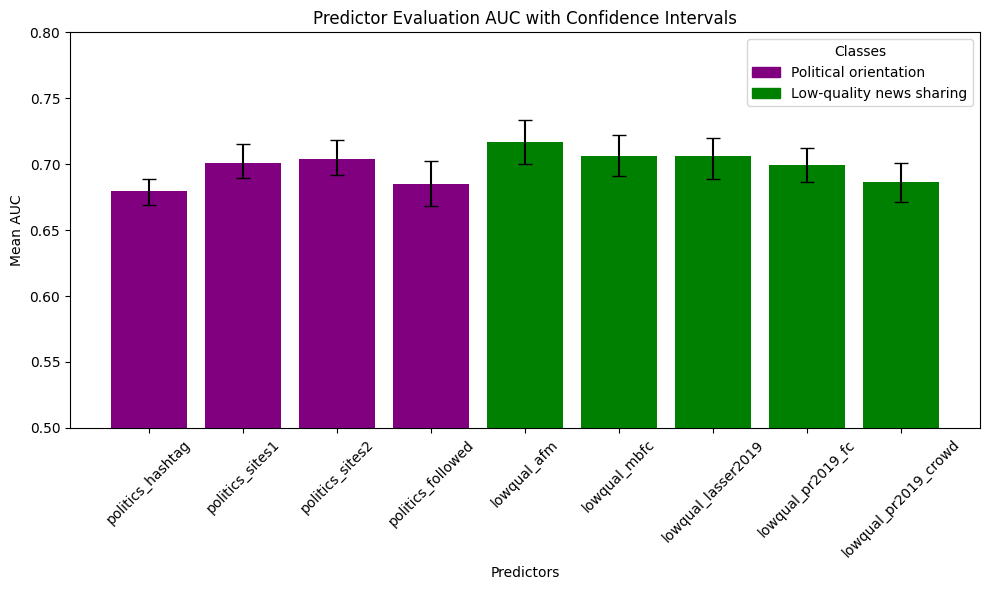

              Predictor  Mean AUC  CI Lower  CI Upper       P-Value
0      politics_hashtag  0.679647  0.669162  0.689076  2.257568e-92
1       politics_sites1  0.700977  0.689440  0.715649  6.100994e-98
2       politics_sites2  0.703650  0.692119  0.718598  5.443086e-90
3     politics_followed  0.685266  0.668351  0.702737  3.374638e-70
4           lowqual_afm  0.716890  0.700387  0.733199  8.546459e-96
5          lowqual_mbfc  0.706291  0.690681  0.722198  4.466891e-82
6    lowqual_lasser2019  0.706464  0.688979  0.719611  1.953982e-89
7     lowqual_pr2019_fc  0.699552  0.686248  0.712157  5.472688e-91
8  lowqual_pr2019_crowd  0.686360  0.670993  0.701267  5.076311e-76
Explained Variance Ratio for pc1_politics: [0.87952937]


In [14]:
# Iterate over predictors

for predictor in predictors:
    aucs = []
    p_values = []  # To store p-values for the predictor
    for _ in range(100):  # Bootstrap 100 times
        # Bootstrap sample
        bootstrap_sample = df.sample(frac=1, replace=True, random_state=np.random.randint(0, 10000))
        y_boot = bootstrap_sample[target]
        X_boot = bootstrap_sample[[predictor]]
        X_boot = sm.add_constant(X_boot)  # Add constant for the intercept term

        # Fit Probit model
        model = Probit(y_boot, X_boot).fit(disp=False)

        # Extract p-value for the predictor (ignore intercept p-value)
        p_value = model.pvalues[predictor]
        p_values.append(p_value)

        # Predict probabilities
        y_pred_prob = model.predict(X_boot)

        # Calculate AUC
        auc = roc_auc_score(y_boot, y_pred_prob)
        aucs.append(auc)

    # Calculate mean AUC and confidence intervals
    mean_auc = np.mean(aucs)
    ci_lower = np.percentile(aucs, 2.5)
    ci_upper = np.percentile(aucs, 97.5)

    # Calculate mean p-value
    mean_p_value = np.mean(p_values)

    results.append({
        'Predictor': predictor,
        'Mean AUC': mean_auc,
        'CI Lower': ci_lower,
        'CI Upper': ci_upper,
        'P-Value': mean_p_value  # Add mean p-value to results
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
# Plot results
plt.figure(figsize=(10, 6))

# Plot bars with corresponding colors and confidence intervals
for i, row in results_df.iterrows():
    color = color_map[row['Predictor']]
    plt.bar(row['Predictor'], row['Mean AUC'], color=color,
            yerr=[[row['Mean AUC'] - row['CI Lower']], [row['CI Upper'] - row['Mean AUC']]],
            capsize=5, align='center', ecolor='black')

# Add legend
handles = [plt.Rectangle((0, 0), 1, 1, color='purple'),
           plt.Rectangle((0, 0), 1, 1, color='green')]
labels = ['Political orientation', 'Low-quality news sharing']
plt.legend(handles, labels, loc='upper right', title='Classes')

# Set labels and title
plt.title('Predictor Evaluation AUC with Confidence Intervals')
plt.xlabel('Predictors')
plt.ylabel('Mean AUC')
plt.xticks(rotation=45)

# Set y-axis limits and custom ticks
plt.ylim(0.5, 0.80)  # Set y-axis limits
plt.yticks(np.arange(0.5, 0.81, 0.05))  # Set y-axis ticks at 0.05 intervals

plt.tight_layout()
plt.show()

# Display results table
print(results_df)
# Display explained variance ratio for pc1_politics
print("Explained Variance Ratio for pc1_politics:", pca_political.explained_variance_ratio_)


The bars represent the `Mean AUC` for each predictor, with error bars indicating the 95% confidence intervals. Predictors related to political orientation are shown in purple, and those related to low-quality news sharing are shown in green.

For misinformation, the specified variables represent indicators of low-quality news sharing. The data is standardized by subtracting the mean and dividing by the standard deviation to ensure comparability across variables. A PCA with one component is applied, resulting in a single principal component `pc1_misinfo`, which captures the maximum variance in the misinformation dataset. This component is added as a new column in the DataFrame.

For harmful language, the specified variables represent various types of abusive or toxic language. The data is similarly standardized, and a PCA with three components is performed. This approach aims to capture more complexity in the harmful language data compared to the misinformation data. The first three principal components `pc1_harmful_language`, `pc2_harmful_language`, and `pc3_harmful_language` are added as new columns in the DataFrame.

In [15]:
# PCA for misinformation (low-quality news sharing)
misinfo_vars = ['lowqual_pr2019_fc', 'lowqual_afm', 'lowqual_lasser2019', 'lowqual_mbfc']
X_misinfo = df[misinfo_vars]

# Standardize the data for PCA
X_misinfo_scaled = (X_misinfo - X_misinfo.mean()) / X_misinfo.std()

# Perform PCA for misinformation
pca_misinfo = PCA(n_components=1)
pc1_misinfo = pca_misinfo.fit_transform(X_misinfo_scaled)

# Add the PCA component to the DataFrame
df['pc1_misinfo'] = pc1_misinfo

# PCA for harmful language
harmful_language_vars = [
    'rewire_abuse', 'rewire_hate', 'rewire_profanity', 'rewire_violent',
    'rewire_sexually_explicit', 'jigsaw_toxicity', 'jigsaw_severe_toxicity',
    'jigsaw_idenity_attack', 'jigsaw_insult', 'jigsaw_profanity', 'jigsaw_threat'
]
X_harmful_language = df[harmful_language_vars]

# Standardize the data for PCA
X_harmful_language_scaled = (X_harmful_language - X_harmful_language.mean()) / X_harmful_language.std()

# Perform PCA for harmful language with three components
pca_harmful_language = PCA(n_components=3)
components_harmful_language = pca_harmful_language.fit_transform(X_harmful_language_scaled)

# Add the PCA components to the DataFrame
df[['pc1_harmful_language', 'pc2_harmful_language', 'pc3_harmful_language']] = components_harmful_language

# Display explained variance ratios for harmful language PCA
print("Explained Variance Ratios for PC1, PC2, and PC3 of Harmful Language:", pca_harmful_language.explained_variance_ratio_)

Explained Variance Ratios for PC1, PC2, and PC3 of Harmful Language: [0.5616608  0.11871792 0.10703707]


This part applies Principal Component Analysis (PCA) to a set of variables related to valence, which includes metrics on emotional tone (negative, neutral, positive) and various harmful or abusive language attributes.

The process begins by selecting the relevant variables and standardizing them. Standardization ensures that each variable has a mean of zero and a standard deviation of one, making them comparable and suitable for PCA.

In [16]:
# PCA for valence
valence_vars = [
    'valence_neg', 'valence_neu', 'valence_pos', 'rewire_hate', 'rewire_profanity',
    'rewire_violent', 'rewire_sexually_explicit', 'jigsaw_toxicity', 'jigsaw_severe_toxicity',
    'jigsaw_idenity_attack', 'jigsaw_insult', 'jigsaw_profanity', 'jigsaw_threat'
]
X_valence = df[valence_vars]

# Standardize the data for PCA
X_valence_scaled = (X_valence - X_valence.mean()) / X_valence.std()

# Perform PCA for valence with one component
pca_valence = PCA(n_components=1)
pc1_valence = pca_valence.fit_transform(X_valence_scaled)

# Add the PCA component to the DataFrame
df['pc1_valence'] = pc1_valence

# Display explained variance ratio for pc1_valence
print("Explained Variance Ratio for pc1_valence:", pca_valence.explained_variance_ratio_)

Explained Variance Ratio for pc1_valence: [0.45107075]


A list of variables to normalize is defined. These include PCA components, activity metrics, and sentiment analysis scores.
Normalization ensures variables have a mean of 0 and standard deviation of 1.
Variables related to social connectivity `log_num_friends`, `log_num_followers`, and `log_fol` are adjusted by adding 1 to avoid issues with the logarithmic scale.
These are standardized and reduced using PCA. To avoid issues with log transformations, one is added to all values. These variables are then standardized before performing PCA to reduce them into a single principal component, which is added to the DataFrame as pc1_fol.

An additional feature, extremity, is computed as the absolute value of pc1_politics, capturing the degree of political orientation irrespective of direction. The moral_outrage variable undergoes winsorization, capping extreme values at the top 1% to mitigate the effect of outliers, and the result is stored as w_moral_outrage.

The predictors for the logistic regression model include various principal components, activity metrics, sentiment analysis scores, and other features relevant to user behavior. These are combined with the target variable suspended, indicating whether an account has been suspended. A constant is added to the predictors to account for the model intercept, and the logistic regression model is fit using the sm.Logit method.

In [ ]:
# Normalize additional variables
variables_to_normalize = [
    'pc1_politics', 'pc1_misinfo', 'log_fol',  # Added 'log_fol'
    'pc1_harmful_language', 'pc2_harmful_language', 'pc3_harmful_language',
    'pc1_valence', 'tweets_in_2wk', 'botsentinel_score', 'extremity',
    'w_moral_outrage', 'liwc_political', 'log_freq_pr_1h',
    'log_repeated_tweet_count', 'barbera_std', 'politics_sites1_std',
    'politics_sites2_ideo_std'
]

# Ensure all variables exist in the DataFrame before normalizing
existing_vars_to_normalize = [var for var in variables_to_normalize if var in df.columns]

# Normalize the selected variables
df[existing_vars_to_normalize] = df[existing_vars_to_normalize].apply(lambda x: (x - x.mean()) / x.std())



# Variables for PC1 calculation
fol_vars = ['log_num_friends', 'log_num_followers', 'log_fol']
fol_data = df[fol_vars] + 1  # Adding 1 to avoid log domain issues

# Standardize the data
fol_data_z = (fol_data - fol_data.mean()) / fol_data.std()

# Perform PCA
pca_fol = PCA(n_components=1)
df['pc1_fol'] = pca_fol.fit_transform(fol_data_z)


df['extremity'] = abs(df['pc1_politics'])  



# Winsorize `moral_outrage` at the top 1%
df['w_moral_outrage'] = mstats.winsorize(df['moral_outrage'], limits=[0, 0.01])




X = df[['pc1_politics', 'pc1_misinfo', 'pc1_fol', 'pc1_harmful_language', 
        'pc2_harmful_language', 'pc3_harmful_language', 'pc1_valence', 
        'tweets_in_2wk', 'botsentinel_score', 'extremity', 
        'w_moral_outrage', 'liwc_political', 'log_freq_pr_1h', 
        'log_repeated_tweet_count', 'barbera_std', 'politics_sites1_std', 
        'politics_sites2_ideo_std']]
y = df['suspended']

# Add a constant for the intercept
X = sm.add_constant(X)

# Fit the logit model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Display the summary of the model
print(result.summary())

# Extract p-values for corrections
p_values = result.pvalues[1:]  # Exclude the intercept

# Apply Bonferroni and Holm-Bonferroni corrections
alpha = 0.05
bonferroni_correction = multipletests(p_values, alpha=alpha, method='bonferroni')
holm_bonferroni_correction = multipletests(p_values, alpha=alpha, method='holm')

# Print corrected p-values
print("Bonferroni corrected p-values:", bonferroni_correction[1])
print("Holm-Bonferroni corrected p-values:", holm_bonferroni_correction[1])

Optimization terminated successfully.
         Current function value: 0.303179
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              suspended   No. Observations:                 9000
Model:                          Logit   Df Residuals:                     8982
Method:                           MLE   Df Model:                           17
Date:                Sat, 07 Dec 2024   Pseudo R-squ.:                  0.1747
Time:                        20:49:33   Log-Likelihood:                -2728.6
converged:                       True   LL-Null:                       -3306.3
Covariance Type:            nonrobust   LLR p-value:                4.804e-235
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.8207      0.266     -6.854      0.000      -2.341

Finally, Bonferroni and Holm-Bonferroni adjustments are applied to the original p-values in the `results_df` DataFrame. The Bonferroni adjustment multiplies each p-value by the total number of tests conducted. The Holm-Bonferroni adjustment sorts p-values in ascending order and multiplies them by the number of remaining comparisons. Both adjustments ensure that the p-values are capped at a maximum value of 1 to maintain validity.

Next, the adjusted p-values are used to identify significant predictors. Significance is determined by comparing adjusted p-values to a threshold of 0.05. The Boolean results are stored in Significant_Bonferroni and Significant_Holm-Bonferroni columns.

A correlation heatmap is plotted to visualize the relationships between the original p-values and the adjusted p-values from both methods. The heatmap uses a coolwarm color scheme to highlight correlations, ranging from -1 to 1, and helps in understanding how adjustments alter the relationships among p-values.

To analyze regression results further, coefficients are visualized using a bar plot. Predictors are displayed along the x-axis, while their respective coefficients are plotted along the y-axis. Predictors are also color-coded based on their significance after the Bonferroni adjustment, providing a clear view of which features are statistically important.

A table is printed that sorts the predictors by their Holm-Bonferroni adjusted p-values, making it easier to identify those with the smallest adjusted values. To address extreme outliers in the original p-values, they are winsorized at the top 1%, reducing their influence on subsequent analysis.

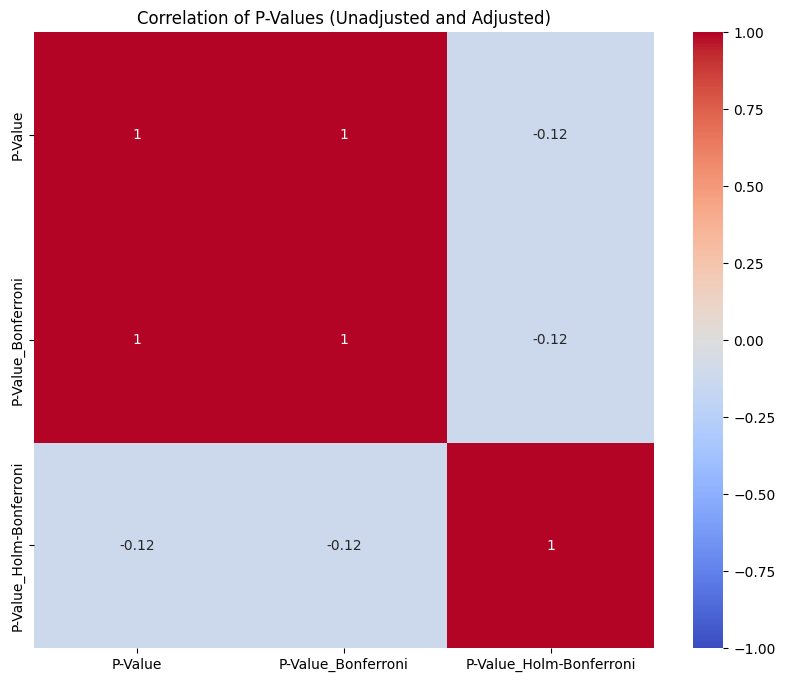

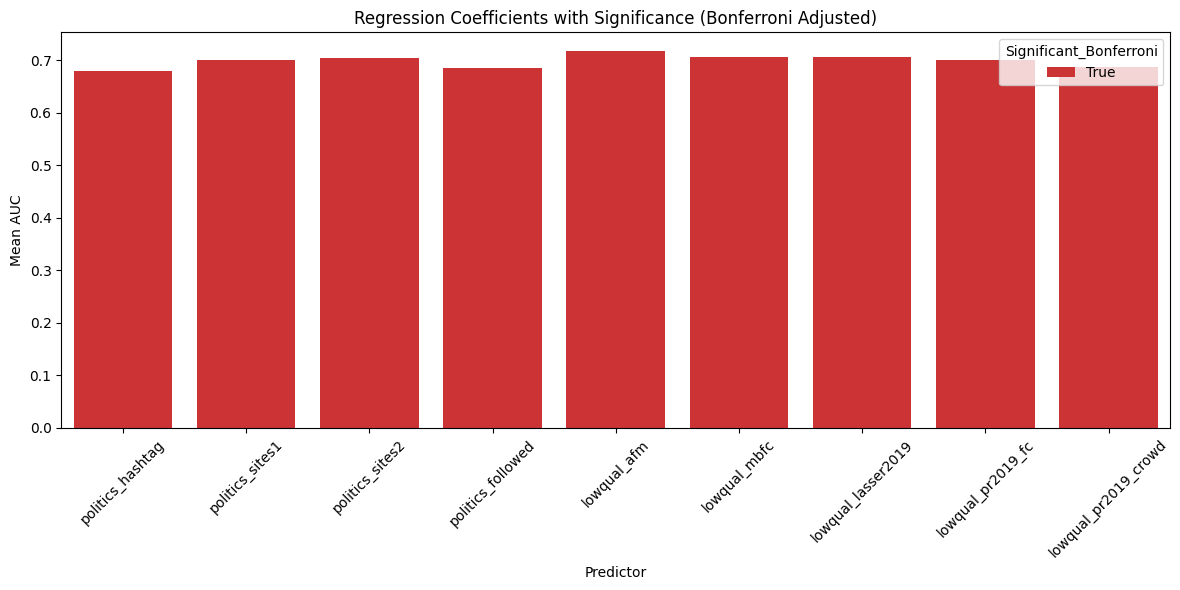

              Predictor  Mean AUC  CI Lower  CI Upper       P-Value  \
0      politics_hashtag  0.679647  0.669162  0.689076  2.257568e-92   
1       politics_sites1  0.700977  0.689440  0.715649  6.100994e-98   
2       politics_sites2  0.703650  0.692119  0.718598  5.443086e-90   
3     politics_followed  0.685266  0.668351  0.702737  3.374638e-70   
4           lowqual_afm  0.716890  0.700387  0.733199  8.546459e-96   
5          lowqual_mbfc  0.706291  0.690681  0.722198  4.466891e-82   
6    lowqual_lasser2019  0.706464  0.688979  0.719611  1.953982e-89   
7     lowqual_pr2019_fc  0.699552  0.686248  0.712157  5.472688e-91   
8  lowqual_pr2019_crowd  0.686360  0.670993  0.701267  5.076311e-76   

   P-Value_Bonferroni  P-Value_Holm-Bonferroni  Significant_Bonferroni  \
0        2.031811e-91             5.490895e-97                    True   
1        5.490895e-97             6.837167e-95                    True   
2        4.898777e-89             1.580298e-91                    T

In [18]:
# Apply corrections for multiple testing using Bonferroni and Holm-Bonferroni
results_df['P-Value_Bonferroni'] = results_df['P-Value'] * len(results_df)
results_df['P-Value_Holm-Bonferroni'] = results_df['P-Value'].sort_values(ascending=True).values * (len(results_df) - np.arange(len(results_df)))

# Adjust p-values to be no larger than 1
results_df['P-Value_Bonferroni'] = results_df['P-Value_Bonferroni'].clip(upper=1)
results_df['P-Value_Holm-Bonferroni'] = results_df['P-Value_Holm-Bonferroni'].clip(upper=1)

# Identify significant variables based on the adjusted p-values
results_df['Significant_Bonferroni'] = results_df['P-Value_Bonferroni'] < 0.05
results_df['Significant_Holm-Bonferroni'] = results_df['P-Value_Holm-Bonferroni'] < 0.05

# Plot a correlation heatmap of p-values
plt.figure(figsize=(10, 8))
correlation_matrix = results_df[['P-Value', 'P-Value_Bonferroni', 'P-Value_Holm-Bonferroni']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of P-Values (Unadjusted and Adjusted)')
plt.show()

# Visualize coefficients and significance
plt.figure(figsize=(12, 6))
sns.barplot(x='Predictor', y='Mean AUC', hue='Significant_Bonferroni', data=results_df)
plt.title('Regression Coefficients with Significance (Bonferroni Adjusted)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Display results
print(results_df.sort_values(by='P-Value_Holm-Bonferroni'))

results_df['P-Value'] = mstats.winsorize(results_df['P-Value'], limits=(0, 0.01))

# Descriptive statistics for p-values and coefficients
print("Descriptive statistics for P-Values:")
print(results_df[['P-Value', 'P-Value_Bonferroni', 'P-Value_Holm-Bonferroni']].describe())

print("\nDescriptive statistics for Coefficients:")
print(results_df['Mean AUC'].describe())

